<a href="https://colab.research.google.com/github/djdunc/casa0018/blob/main/Week3/CASA0018_3_1_train_hello_world_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Train a Simple TensorFlow Lite for Microcontrollers model

This notebook demonstrates the process of training a 2.5 kB model using TensorFlow and converting it for use with TensorFlow Lite for Microcontrollers. 

Deep learning networks learn to model patterns in underlying data. Here, we're going to train a network to model data generated by a [sine](https://en.wikipedia.org/wiki/Sine) function. This will result in a model that can take a value, `x`, and predict its sine, `y`.

The model created in this notebook is used in the [hello_world](https://github.com/tensorflow/tensorflow/tree/master/tensorflow/lite/micro/examples/hello_world) example for [TensorFlow Lite for MicroControllers](https://www.tensorflow.org/lite/microcontrollers/overview).

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/tensorflow/blob/master/tensorflow/lite/micro/examples/hello_world/train/train_hello_world_model.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/tensorflow/blob/master/tensorflow/lite/micro/examples/hello_world/train/train_hello_world_model.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

## Configure Defaults
Define some variables to point to file locations.

In [1]:
# Define paths to model files
import os
MODELS_DIR = 'models/'
if not os.path.exists(MODELS_DIR):
    os.mkdir(MODELS_DIR)
MODEL_TF = MODELS_DIR + 'model'
MODEL_NO_QUANT_TFLITE = MODELS_DIR + 'model_no_quant.tflite'
MODEL_TFLITE = MODELS_DIR + 'model.tflite'
MODEL_TFLITE_MICRO = MODELS_DIR + 'model.cc'

## Setup Environment

Import Dependencies and give them some aliases so that they are easier to read in the code.

We set a random number seed so that you can get repeatable model results or you can tweak it to vary the model output if you want to experiment. Note - if you set a different seed number your graphs and results will look different!

In [2]:
# TensorFlow is an open source machine learning library
import tensorflow as tf

# Keras is TensorFlow's high-level API for deep learning
from tensorflow import keras
# Numpy is a math library
import numpy as np
# Pandas is a data manipulation library 
import pandas as pd
# Matplotlib is a graphing library
import matplotlib.pyplot as plt
# Math is Python's math library
import math

# Set seed for experiment reproducibility
seed = 1337
np.random.seed(seed)
tf.random.set_seed(seed)

## Creating a Dataset

### 1. Generate Data

The code in the following cell will generate a set of random `x` values, calculate their sine values, and display them on a graph. 

Note that we shuffle the values so that they are not in order which makes the splitting of training, validation and test data easier at the next stage.

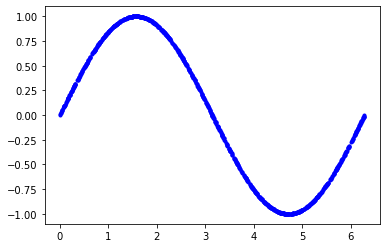

In [3]:
# Number of sample datapoints
SAMPLES = 1000

# Generate a uniformly distributed set of random numbers in the range from
# 0 to 2π, which covers a complete sine wave oscillation
x_values = np.random.uniform(
    low=0, high=2*math.pi, size=SAMPLES).astype(np.float32)

# Shuffle the values to guarantee they're not in order
np.random.shuffle(x_values)

# Calculate the corresponding sine values
y_values = np.sin(x_values).astype(np.float32)

# Plot our data. The 'b.' argument tells the library to print blue dots.
plt.plot(x_values, y_values, 'b.')
plt.show()

### 2. Add Noise
Since it was generated directly by the sine function, our data fits a nice, smooth curve.

However, machine learning models are good at extracting underlying meaning from messy, real world data. To demonstrate this, we can add some noise to our data to approximate something more life-like.

In the following cell, we'll add some random noise to each value, then draw a new graph:

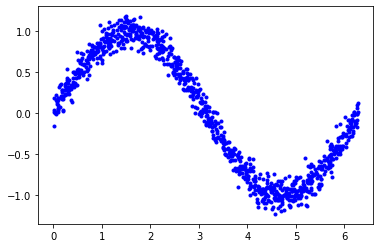

In [4]:
# Add a small random number to each y value
y_values += 0.1 * np.random.randn(*y_values.shape)

# Plot our data
plt.plot(x_values, y_values, 'b.')
plt.show()

### 3. Split the Data
We now have a noisy dataset that approximates real world data. We'll be using this to train our model.

To evaluate the accuracy of the model we train, we'll need to compare its predictions to real data and check how well they match up. This evaluation happens during training (where it is referred to as validation) and after training (referred to as testing).

The data is split as follows:
  1. Training: 60%
  2. Validation: 20%
  3. Testing: 20% 

The following code will split our data and then plots each set as a different color:


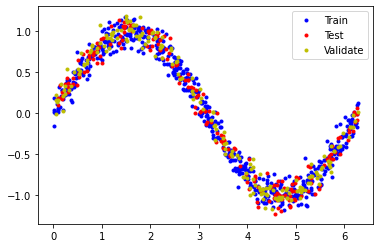

In [5]:
# We'll use 60% of our data for training and 20% for testing. The remaining 20%
# will be used for validation. Calculate the indices of each section.
TRAIN_SPLIT =  int(0.6 * SAMPLES)
TEST_SPLIT = int(0.2 * SAMPLES + TRAIN_SPLIT)

# Use np.split to chop our data into three parts.
# The second argument to np.split is an array of indices where the data will be
# split. We provide two indices, so the data will be divided into three chunks.
x_train, x_test, x_validate = np.split(x_values, [TRAIN_SPLIT, TEST_SPLIT])
y_train, y_test, y_validate = np.split(y_values, [TRAIN_SPLIT, TEST_SPLIT])

# Double check that our splits add up correctly
assert (x_train.size + x_validate.size + x_test.size) ==  SAMPLES

# Plot the data in each partition in different colors:
plt.plot(x_train, y_train, 'b.', label="Train")
plt.plot(x_test, y_test, 'r.', label="Test")
plt.plot(x_validate, y_validate, 'y.', label="Validate")
plt.legend()
plt.show()

## Training

### 1. Design the Model
We're going to build a simple neural network model that will take an input value (in this case, `x`) and use it to predict a numeric output value (the sine of `x`). This type of problem is called a _regression_. It will use _layers_ of _neurons_ to attempt to learn any patterns underlying the training data, so it can make predictions.

To begin with, we'll define two layers. The first layer takes a single input (our `x` value) and runs it through 8 neurons. Based on this input, each neuron will become _activated_ to a certain degree based on its internal state (its _weight_ and _bias_ values). A neuron's degree of activation is expressed as a number. Remember:
**activation = activation_function((input * weight) + bias)** - but we don't see this here since it is handled under the hood by Keras.

The activation numbers from our first layer will be fed as inputs to our second layer, which is a single neuron. It will apply its own weights and bias to these inputs and calculate its own activation, which will be output as our `y` value.

The code in the following cell defines our model using [Keras](https://www.tensorflow.org/guide/keras), TensorFlow's high-level API for creating deep learning networks. 

In [6]:
# We'll use Keras to create a simple model architecture
model_1 = tf.keras.Sequential()

# First layer takes a scalar input and feeds it through 8 "neurons". The
# neurons decide whether to activate based on the 'relu' activation function.
model_1.add(keras.layers.Dense(8, activation='relu', input_shape=(1,)))

# Final layer is a single neuron, since we want to output a single value
model_1.add(keras.layers.Dense(1))

Once the network is defined, we _compile_ it, specifying parameters that determine how it will be trained:

In [7]:
# Compile the model using the standard 'adam' optimizer and 
# the mean squared error or 'mse' loss function for regression and mean abs error as a metric.
model_1.compile(optimizer='adam', loss='mse', metrics=['mae'])
model_1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 16        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 25
Trainable params: 25
Non-trainable params: 0
_________________________________________________________________


### 2. Train the Model
Once we've defined the model, we can use our data to _train_ it. Training involves passing an `x` value into the neural network, checking how far the network's output deviates from the expected `y` value, and adjusting the neurons' weights and biases so that the output is more likely to be correct the next time.

Training runs this process on the full dataset multiple times, and each full run-through is known as an epoch. The number of **_epochs_** to run during training is a parameter we can set.

During each epoch, data is run through the network in multiple batches. For each batch, several pieces of data are passed into the network, producing output values. These outputs' correctness is measured in aggregate and the network's weights and biases are adjusted accordingly, once per batch. The **_batch size_** is also a parameter we can set.

The code in the following cell **uses the `x` and `y` values from our training data to train the model. It runs for 500 _epochs_, with 64 pieces of data in each _batch_. We also pass in some data for _validation_**. As you will see when you run the cell, training can take a while to complete:



In [8]:
# Train the model on our training data while validating on our validation set
history_1 = model_1.fit(x_train, y_train, epochs=500, batch_size=64,
                        validation_data=(x_validate, y_validate))

Epoch 1/500
10/10 [==============================] - 1s 85ms/step - loss: 4.1874 - mae: 1.6039 - val_loss: 3.8578 - val_mae: 1.5500
Epoch 2/500
10/10 [==============================] - 0s 6ms/step - loss: 3.4436 - mae: 1.4600 - val_loss: 3.2823 - val_mae: 1.4523
Epoch 3/500
10/10 [==============================] - 0s 5ms/step - loss: 2.9375 - mae: 1.3673 - val_loss: 2.7765 - val_mae: 1.3619
Epoch 4/500
10/10 [==============================] - 0s 5ms/step - loss: 2.4713 - mae: 1.2646 - val_loss: 2.3525 - val_mae: 1.2801
Epoch 5/500
10/10 [==============================] - 0s 6ms/step - loss: 2.1840 - mae: 1.2175 - val_loss: 2.0002 - val_mae: 1.2064
Epoch 6/500
10/10 [==============================] - 0s 5ms/step - loss: 1.6979 - mae: 1.0900 - val_loss: 1.7090 - val_mae: 1.1384
Epoch 7/500
10/10 [==============================] - 0s 7ms/step - loss: 1.5685 - mae: 1.0716 - val_loss: 1.4619 - val_mae: 1.0741
Epoch 8/500
10/10 [==============================] - 0s 7ms/step - loss: 1.2639 - 

10/10 [==============================] - 0s 4ms/step - loss: 0.3002 - mae: 0.4794 - val_loss: 0.3570 - val_mae: 0.5217
Epoch 64/500
10/10 [==============================] - 0s 5ms/step - loss: 0.3129 - mae: 0.4892 - val_loss: 0.3521 - val_mae: 0.5181
Epoch 65/500
10/10 [==============================] - 0s 5ms/step - loss: 0.3102 - mae: 0.4848 - val_loss: 0.3475 - val_mae: 0.5150
Epoch 66/500
10/10 [==============================] - 0s 5ms/step - loss: 0.2862 - mae: 0.4634 - val_loss: 0.3430 - val_mae: 0.5114
Epoch 67/500
10/10 [==============================] - 0s 6ms/step - loss: 0.2933 - mae: 0.4712 - val_loss: 0.3384 - val_mae: 0.5081
Epoch 68/500
10/10 [==============================] - 0s 5ms/step - loss: 0.2919 - mae: 0.4702 - val_loss: 0.3340 - val_mae: 0.5048
Epoch 69/500
10/10 [==============================] - 0s 5ms/step - loss: 0.2816 - mae: 0.4634 - val_loss: 0.3298 - val_mae: 0.5021
Epoch 70/500
10/10 [==============================] - 0s 5ms/step - loss: 0.2904 - mae: 0

Epoch 125/500
10/10 [==============================] - 0s 6ms/step - loss: 0.1790 - mae: 0.3685 - val_loss: 0.2015 - val_mae: 0.3953
Epoch 126/500
10/10 [==============================] - 0s 5ms/step - loss: 0.1834 - mae: 0.3756 - val_loss: 0.2002 - val_mae: 0.3938
Epoch 127/500
10/10 [==============================] - 0s 7ms/step - loss: 0.1853 - mae: 0.3752 - val_loss: 0.1994 - val_mae: 0.3931
Epoch 128/500
10/10 [==============================] - 0s 7ms/step - loss: 0.1789 - mae: 0.3675 - val_loss: 0.1984 - val_mae: 0.3921
Epoch 129/500
10/10 [==============================] - 0s 6ms/step - loss: 0.1896 - mae: 0.3807 - val_loss: 0.1981 - val_mae: 0.3918
Epoch 130/500
10/10 [==============================] - 0s 5ms/step - loss: 0.1803 - mae: 0.3727 - val_loss: 0.1972 - val_mae: 0.3909
Epoch 131/500
10/10 [==============================] - 0s 6ms/step - loss: 0.1749 - mae: 0.3660 - val_loss: 0.1963 - val_mae: 0.3899
Epoch 132/500
10/10 [==============================] - 0s 7ms/step - 

10/10 [==============================] - 0s 5ms/step - loss: 0.1687 - mae: 0.3485 - val_loss: 0.1734 - val_mae: 0.3590
Epoch 187/500
10/10 [==============================] - 0s 7ms/step - loss: 0.1828 - mae: 0.3656 - val_loss: 0.1729 - val_mae: 0.3583
Epoch 188/500
10/10 [==============================] - 0s 5ms/step - loss: 0.1665 - mae: 0.3481 - val_loss: 0.1724 - val_mae: 0.3577
Epoch 189/500
10/10 [==============================] - 0s 5ms/step - loss: 0.1696 - mae: 0.3534 - val_loss: 0.1722 - val_mae: 0.3573
Epoch 190/500
10/10 [==============================] - 0s 5ms/step - loss: 0.1641 - mae: 0.3412 - val_loss: 0.1729 - val_mae: 0.3580
Epoch 191/500
10/10 [==============================] - 0s 4ms/step - loss: 0.1669 - mae: 0.3486 - val_loss: 0.1724 - val_mae: 0.3574
Epoch 192/500
10/10 [==============================] - 0s 5ms/step - loss: 0.1586 - mae: 0.3395 - val_loss: 0.1723 - val_mae: 0.3571
Epoch 193/500
10/10 [==============================] - 0s 5ms/step - loss: 0.1716 -

Epoch 248/500
10/10 [==============================] - 0s 6ms/step - loss: 0.1573 - mae: 0.3313 - val_loss: 0.1648 - val_mae: 0.3449
Epoch 249/500
10/10 [==============================] - 0s 5ms/step - loss: 0.1597 - mae: 0.3324 - val_loss: 0.1638 - val_mae: 0.3438
Epoch 250/500
10/10 [==============================] - 0s 4ms/step - loss: 0.1623 - mae: 0.3357 - val_loss: 0.1630 - val_mae: 0.3427
Epoch 251/500
10/10 [==============================] - 0s 5ms/step - loss: 0.1639 - mae: 0.3338 - val_loss: 0.1630 - val_mae: 0.3427
Epoch 252/500
10/10 [==============================] - 0s 5ms/step - loss: 0.1662 - mae: 0.3407 - val_loss: 0.1635 - val_mae: 0.3433
Epoch 253/500
10/10 [==============================] - 0s 5ms/step - loss: 0.1544 - mae: 0.3255 - val_loss: 0.1635 - val_mae: 0.3432
Epoch 254/500
10/10 [==============================] - 0s 6ms/step - loss: 0.1594 - mae: 0.3336 - val_loss: 0.1630 - val_mae: 0.3426
Epoch 255/500
10/10 [==============================] - 0s 4ms/step - 

10/10 [==============================] - 0s 5ms/step - loss: 0.1483 - mae: 0.3205 - val_loss: 0.1596 - val_mae: 0.3365
Epoch 310/500
10/10 [==============================] - 0s 5ms/step - loss: 0.1603 - mae: 0.3307 - val_loss: 0.1609 - val_mae: 0.3381
Epoch 311/500
10/10 [==============================] - 0s 4ms/step - loss: 0.1656 - mae: 0.3370 - val_loss: 0.1598 - val_mae: 0.3367
Epoch 312/500
10/10 [==============================] - 0s 6ms/step - loss: 0.1508 - mae: 0.3254 - val_loss: 0.1591 - val_mae: 0.3356
Epoch 313/500
10/10 [==============================] - 0s 4ms/step - loss: 0.1632 - mae: 0.3353 - val_loss: 0.1595 - val_mae: 0.3361
Epoch 314/500
10/10 [==============================] - 0s 4ms/step - loss: 0.1589 - mae: 0.3288 - val_loss: 0.1595 - val_mae: 0.3362
Epoch 315/500
10/10 [==============================] - 0s 4ms/step - loss: 0.1618 - mae: 0.3317 - val_loss: 0.1598 - val_mae: 0.3366
Epoch 316/500
10/10 [==============================] - 0s 4ms/step - loss: 0.1702 -

Epoch 371/500
10/10 [==============================] - 0s 4ms/step - loss: 0.1454 - mae: 0.3147 - val_loss: 0.1599 - val_mae: 0.3357
Epoch 372/500
10/10 [==============================] - 0s 4ms/step - loss: 0.1542 - mae: 0.3255 - val_loss: 0.1586 - val_mae: 0.3343
Epoch 373/500
10/10 [==============================] - 0s 4ms/step - loss: 0.1545 - mae: 0.3245 - val_loss: 0.1576 - val_mae: 0.3330
Epoch 374/500
10/10 [==============================] - 0s 4ms/step - loss: 0.1471 - mae: 0.3162 - val_loss: 0.1577 - val_mae: 0.3330
Epoch 375/500
10/10 [==============================] - 0s 4ms/step - loss: 0.1532 - mae: 0.3250 - val_loss: 0.1574 - val_mae: 0.3324
Epoch 376/500
10/10 [==============================] - 0s 5ms/step - loss: 0.1528 - mae: 0.3177 - val_loss: 0.1584 - val_mae: 0.3339
Epoch 377/500
10/10 [==============================] - 0s 5ms/step - loss: 0.1606 - mae: 0.3300 - val_loss: 0.1582 - val_mae: 0.3336
Epoch 378/500
10/10 [==============================] - 0s 5ms/step - 

10/10 [==============================] - 0s 4ms/step - loss: 0.1542 - mae: 0.3217 - val_loss: 0.1560 - val_mae: 0.3296
Epoch 433/500
10/10 [==============================] - 0s 4ms/step - loss: 0.1591 - mae: 0.3290 - val_loss: 0.1572 - val_mae: 0.3313
Epoch 434/500
10/10 [==============================] - 0s 4ms/step - loss: 0.1583 - mae: 0.3202 - val_loss: 0.1578 - val_mae: 0.3320
Epoch 435/500
10/10 [==============================] - 0s 4ms/step - loss: 0.1569 - mae: 0.3225 - val_loss: 0.1556 - val_mae: 0.3292
Epoch 436/500
10/10 [==============================] - 0s 4ms/step - loss: 0.1511 - mae: 0.3128 - val_loss: 0.1556 - val_mae: 0.3291
Epoch 437/500
10/10 [==============================] - 0s 4ms/step - loss: 0.1559 - mae: 0.3238 - val_loss: 0.1563 - val_mae: 0.3299
Epoch 438/500
10/10 [==============================] - 0s 4ms/step - loss: 0.1571 - mae: 0.3253 - val_loss: 0.1576 - val_mae: 0.3316
Epoch 439/500
10/10 [==============================] - 0s 4ms/step - loss: 0.1609 -

Epoch 494/500
10/10 [==============================] - 0s 5ms/step - loss: 0.1548 - mae: 0.3159 - val_loss: 0.1560 - val_mae: 0.3291
Epoch 495/500
10/10 [==============================] - 0s 5ms/step - loss: 0.1534 - mae: 0.3195 - val_loss: 0.1546 - val_mae: 0.3270
Epoch 496/500
10/10 [==============================] - 0s 4ms/step - loss: 0.1653 - mae: 0.3304 - val_loss: 0.1557 - val_mae: 0.3284
Epoch 497/500
10/10 [==============================] - 0s 4ms/step - loss: 0.1581 - mae: 0.3253 - val_loss: 0.1563 - val_mae: 0.3293
Epoch 498/500
10/10 [==============================] - 0s 4ms/step - loss: 0.1497 - mae: 0.3200 - val_loss: 0.1569 - val_mae: 0.3299
Epoch 499/500
10/10 [==============================] - 0s 4ms/step - loss: 0.1580 - mae: 0.3236 - val_loss: 0.1566 - val_mae: 0.3295
Epoch 500/500
10/10 [==============================] - 0s 4ms/step - loss: 0.1638 - mae: 0.3279 - val_loss: 0.1561 - val_mae: 0.3290


### 3. Plot Metrics

**Loss (or Mean Squared Error)**

During training, the model's performance is constantly being measured against both our training data and the validation data that we set aside earlier. 

Training produces a log of data that tells us how the model's performance changed over the course of the training process. The following cells will display some of that data in a graphical form:

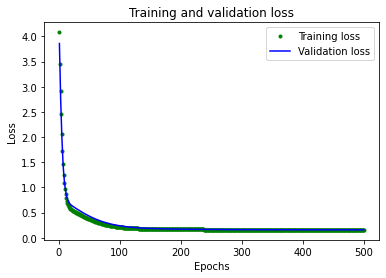

In [9]:
# Draw a graph of the loss, which is the distance between
# the predicted and actual values during training and validation.
#print(history_1.history.keys())

train_loss = history_1.history['loss']
val_loss = history_1.history['val_loss']

epochs = range(1, len(train_loss) + 1)

plt.plot(epochs, train_loss, 'g.', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

The graph shows the _loss_ (or the difference between the model's predictions and the actual data) for each epoch. There are several ways to calculate loss, and the method we have used is _mean squared error_. There is a distinct loss value given for the training and the validation data.

As we can see, the amount of loss rapidly decreases over the first 25 epochs, before flattening out. This means that the model is improving and producing more accurate predictions!

Our goal is to stop training when either the model is no longer improving, or when the _training loss_ is less than the _validation loss_, which would mean that the model has learned to predict the training data so well that it can no longer generalize to new data.

To make the flatter part of the graph more readable, let's skip the first 100 epochs:

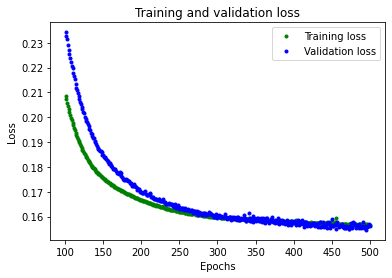

In [10]:
# Exclude the first few epochs so the graph is easier to read
SKIP = 100

plt.plot(epochs[SKIP:], train_loss[SKIP:], 'g.', label='Training loss')
plt.plot(epochs[SKIP:], val_loss[SKIP:], 'b.', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

From the plot, we can see that loss continues to reduce until around 200 epochs, at which point it is mostly stable. This means that there's no need to train our network beyond 200 epochs.

However, we can also see that the lowest loss value is still around 0.155. This means that our network's predictions are off by an average of ~15%. 

**2. Mean Absolute Error**

To gain more insight into our model's performance we can plot some more data. This time, we'll plot the _mean absolute error_, which is another way of measuring how far the network's predictions are from the actual numbers:

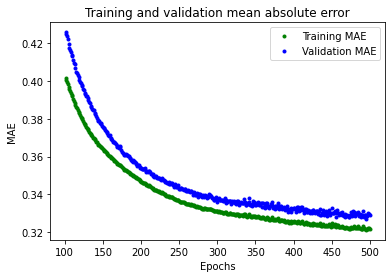

In [11]:
plt.clf()

# Draw a graph of mean absolute error, which is another way of
# measuring the amount of error in the prediction.
train_mae = history_1.history['mae']
val_mae = history_1.history['val_mae']

plt.plot(epochs[SKIP:], train_mae[SKIP:], 'g.', label='Training MAE')
plt.plot(epochs[SKIP:], val_mae[SKIP:], 'b.', label='Validation MAE')
plt.title('Training and validation mean absolute error')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.show()

This graph of _mean absolute error_ tells another story. We can see that training data shows consistently lower error than validation data, which means that the network may have _overfit_, or learned the training data so rigidly that it can't make effective predictions about new data.

In addition, the mean absolute error values are quite high, >0.3 at best, which means some of the model's predictions are at least 30% off. A 30% error means we are very far from accurately modelling the sine wave function.

**3. Actual vs Predicted Outputs**

To get more insight into what is happening, let's check its predictions against the test dataset we set aside earlier:

7/7 [==============================] - 0s 1ms/step - loss: 0.1611 - mae: 0.3259


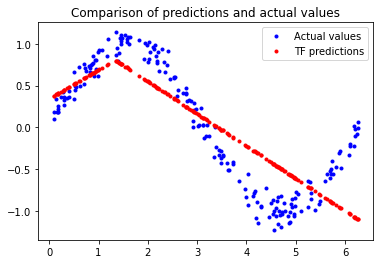

In [12]:
# Calculate and print the loss on our test dataset
test_loss, test_mae = model_1.evaluate(x_test, y_test)

# Make predictions based on our test dataset
y_test_pred = model_1.predict(x_test)

# Graph the predictions against the actual values
plt.clf()
plt.title('Comparison of predictions and actual values')
plt.plot(x_test, y_test, 'b.', label='Actual values')
plt.plot(x_test, y_test_pred, 'r.', label='TF predictions')
plt.legend()
plt.show()

Oh dear! The graph makes it clear that our network has learned to approximate the sine function in a very limited way.

The rigidity of this fit suggests that the model does not have enough capacity to learn the full complexity of the sine wave function, so it's only able to approximate it in an overly simplistic way. By making our model bigger, we should be able to improve its performance.

## Training a Larger Model

### 1. Re-Design the Model
To make our model bigger, let's add an additional layer of neurons. The following cell redefines our model in the same way as earlier, but with 16 neurons in the first layer and an additional layer of 16 neurons in the middle:

In [13]:
model = tf.keras.Sequential()

# First layer takes a scalar input and feeds it through 16 "neurons". The
# neurons decide whether to activate based on the 'relu' activation function.
model.add(keras.layers.Dense(16, activation='relu', input_shape=(1,)))

# The new second and third layer will help the network learn more complex representations
model.add(keras.layers.Dense(16, activation='relu'))

# Final layer is a single neuron, since we want to output a single value
model.add(keras.layers.Dense(1))

# Compile the model using the standard 'adam' optimizer and the mean squared error or 'mse' loss function for regression.
model.compile(optimizer='adam', loss="mse", metrics=["mae"])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 16)                32        
_________________________________________________________________
dense_3 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 17        
Total params: 321
Trainable params: 321
Non-trainable params: 0
_________________________________________________________________


### 2. Re-Train the Model ###

We'll now train and save the new model.

In [14]:
# Train the model
history = model.fit(x_train, y_train, epochs=500, batch_size=64,
                    validation_data=(x_validate, y_validate))

# Save the model to disk
model.save(MODEL_TF)

Epoch 1/500
10/10 [==============================] - 1s 23ms/step - loss: 1.4994 - mae: 1.0141 - val_loss: 1.1876 - val_mae: 0.9692
Epoch 2/500
10/10 [==============================] - 0s 5ms/step - loss: 0.9254 - mae: 0.8366 - val_loss: 0.8106 - val_mae: 0.8305
Epoch 3/500
10/10 [==============================] - 0s 5ms/step - loss: 0.6366 - mae: 0.7181 - val_loss: 0.6183 - val_mae: 0.7205
Epoch 4/500
10/10 [==============================] - 0s 5ms/step - loss: 0.4891 - mae: 0.6244 - val_loss: 0.5478 - val_mae: 0.6578
Epoch 5/500
10/10 [==============================] - 0s 6ms/step - loss: 0.4494 - mae: 0.5878 - val_loss: 0.5143 - val_mae: 0.6248
Epoch 6/500
10/10 [==============================] - 0s 6ms/step - loss: 0.4357 - mae: 0.5696 - val_loss: 0.4863 - val_mae: 0.6083
Epoch 7/500
10/10 [==============================] - 0s 6ms/step - loss: 0.3997 - mae: 0.5453 - val_loss: 0.4608 - val_mae: 0.5909
Epoch 8/500
10/10 [==============================] - 0s 6ms/step - loss: 0.3907 - 

10/10 [==============================] - 0s 5ms/step - loss: 0.0885 - mae: 0.2234 - val_loss: 0.0732 - val_mae: 0.2012
Epoch 64/500
10/10 [==============================] - 0s 6ms/step - loss: 0.0832 - mae: 0.2164 - val_loss: 0.0722 - val_mae: 0.1990
Epoch 65/500
10/10 [==============================] - 0s 5ms/step - loss: 0.0757 - mae: 0.2066 - val_loss: 0.0728 - val_mae: 0.2009
Epoch 66/500
10/10 [==============================] - 0s 5ms/step - loss: 0.0791 - mae: 0.2080 - val_loss: 0.0739 - val_mae: 0.2037
Epoch 67/500
10/10 [==============================] - 0s 5ms/step - loss: 0.0850 - mae: 0.2159 - val_loss: 0.0719 - val_mae: 0.1990
Epoch 68/500
10/10 [==============================] - 0s 6ms/step - loss: 0.0777 - mae: 0.2079 - val_loss: 0.0707 - val_mae: 0.1958
Epoch 69/500
10/10 [==============================] - 0s 5ms/step - loss: 0.0814 - mae: 0.2112 - val_loss: 0.0714 - val_mae: 0.1978
Epoch 70/500
10/10 [==============================] - 0s 5ms/step - loss: 0.0731 - mae: 0

Epoch 125/500
10/10 [==============================] - 0s 5ms/step - loss: 0.0556 - mae: 0.1734 - val_loss: 0.0532 - val_mae: 0.1703
Epoch 126/500
10/10 [==============================] - 0s 4ms/step - loss: 0.0587 - mae: 0.1784 - val_loss: 0.0505 - val_mae: 0.1631
Epoch 127/500
10/10 [==============================] - 0s 6ms/step - loss: 0.0550 - mae: 0.1698 - val_loss: 0.0504 - val_mae: 0.1634
Epoch 128/500
10/10 [==============================] - 0s 5ms/step - loss: 0.0540 - mae: 0.1700 - val_loss: 0.0504 - val_mae: 0.1634
Epoch 129/500
10/10 [==============================] - 0s 5ms/step - loss: 0.0611 - mae: 0.1817 - val_loss: 0.0520 - val_mae: 0.1685
Epoch 130/500
10/10 [==============================] - 0s 5ms/step - loss: 0.0543 - mae: 0.1725 - val_loss: 0.0494 - val_mae: 0.1620
Epoch 131/500
10/10 [==============================] - 0s 6ms/step - loss: 0.0528 - mae: 0.1698 - val_loss: 0.0495 - val_mae: 0.1630
Epoch 132/500
10/10 [==============================] - 0s 5ms/step - 

10/10 [==============================] - 0s 5ms/step - loss: 0.0365 - mae: 0.1398 - val_loss: 0.0322 - val_mae: 0.1370
Epoch 187/500
10/10 [==============================] - 0s 5ms/step - loss: 0.0415 - mae: 0.1516 - val_loss: 0.0310 - val_mae: 0.1336
Epoch 188/500
10/10 [==============================] - 0s 7ms/step - loss: 0.0351 - mae: 0.1405 - val_loss: 0.0305 - val_mae: 0.1322
Epoch 189/500
10/10 [==============================] - 0s 5ms/step - loss: 0.0352 - mae: 0.1408 - val_loss: 0.0305 - val_mae: 0.1332
Epoch 190/500
10/10 [==============================] - 0s 7ms/step - loss: 0.0349 - mae: 0.1380 - val_loss: 0.0314 - val_mae: 0.1374
Epoch 191/500
10/10 [==============================] - 0s 16ms/step - loss: 0.0347 - mae: 0.1396 - val_loss: 0.0294 - val_mae: 0.1303
Epoch 192/500
10/10 [==============================] - 0s 8ms/step - loss: 0.0304 - mae: 0.1300 - val_loss: 0.0297 - val_mae: 0.1320
Epoch 193/500
10/10 [==============================] - 0s 18ms/step - loss: 0.0351

10/10 [==============================] - 0s 5ms/step - loss: 0.0193 - mae: 0.1082 - val_loss: 0.0166 - val_mae: 0.1002
Epoch 248/500
10/10 [==============================] - 0s 5ms/step - loss: 0.0182 - mae: 0.1042 - val_loss: 0.0170 - val_mae: 0.1047
Epoch 249/500
10/10 [==============================] - 0s 5ms/step - loss: 0.0176 - mae: 0.1026 - val_loss: 0.0153 - val_mae: 0.0983
Epoch 250/500
10/10 [==============================] - 0s 5ms/step - loss: 0.0193 - mae: 0.1076 - val_loss: 0.0172 - val_mae: 0.1058
Epoch 251/500
10/10 [==============================] - 0s 5ms/step - loss: 0.0197 - mae: 0.1071 - val_loss: 0.0151 - val_mae: 0.0984
Epoch 252/500
10/10 [==============================] - 0s 6ms/step - loss: 0.0196 - mae: 0.1080 - val_loss: 0.0178 - val_mae: 0.1081
Epoch 253/500
10/10 [==============================] - 0s 5ms/step - loss: 0.0182 - mae: 0.1074 - val_loss: 0.0157 - val_mae: 0.1000
Epoch 254/500
10/10 [==============================] - 0s 5ms/step - loss: 0.0191 -

Epoch 309/500
10/10 [==============================] - 0s 5ms/step - loss: 0.0134 - mae: 0.0905 - val_loss: 0.0107 - val_mae: 0.0824
Epoch 310/500
10/10 [==============================] - 0s 4ms/step - loss: 0.0144 - mae: 0.0958 - val_loss: 0.0123 - val_mae: 0.0894
Epoch 311/500
10/10 [==============================] - 0s 5ms/step - loss: 0.0133 - mae: 0.0918 - val_loss: 0.0112 - val_mae: 0.0838
Epoch 312/500
10/10 [==============================] - 0s 5ms/step - loss: 0.0127 - mae: 0.0881 - val_loss: 0.0120 - val_mae: 0.0886
Epoch 313/500
10/10 [==============================] - 0s 5ms/step - loss: 0.0137 - mae: 0.0926 - val_loss: 0.0109 - val_mae: 0.0834
Epoch 314/500
10/10 [==============================] - 0s 8ms/step - loss: 0.0127 - mae: 0.0889 - val_loss: 0.0110 - val_mae: 0.0851
Epoch 315/500
10/10 [==============================] - 0s 5ms/step - loss: 0.0126 - mae: 0.0889 - val_loss: 0.0111 - val_mae: 0.0841
Epoch 316/500
10/10 [==============================] - 0s 4ms/step - 

10/10 [==============================] - 0s 4ms/step - loss: 0.0127 - mae: 0.0907 - val_loss: 0.0123 - val_mae: 0.0897
Epoch 371/500
10/10 [==============================] - 0s 5ms/step - loss: 0.0127 - mae: 0.0899 - val_loss: 0.0098 - val_mae: 0.0776
Epoch 372/500
10/10 [==============================] - 0s 4ms/step - loss: 0.0119 - mae: 0.0864 - val_loss: 0.0103 - val_mae: 0.0819
Epoch 373/500
10/10 [==============================] - 0s 5ms/step - loss: 0.0123 - mae: 0.0882 - val_loss: 0.0101 - val_mae: 0.0803
Epoch 374/500
10/10 [==============================] - 0s 5ms/step - loss: 0.0125 - mae: 0.0879 - val_loss: 0.0104 - val_mae: 0.0805
Epoch 375/500
10/10 [==============================] - 0s 5ms/step - loss: 0.0114 - mae: 0.0855 - val_loss: 0.0102 - val_mae: 0.0814
Epoch 376/500
10/10 [==============================] - 0s 7ms/step - loss: 0.0126 - mae: 0.0899 - val_loss: 0.0098 - val_mae: 0.0781
Epoch 377/500
10/10 [==============================] - 0s 5ms/step - loss: 0.0122 -

Epoch 432/500
10/10 [==============================] - 0s 5ms/step - loss: 0.0111 - mae: 0.0833 - val_loss: 0.0097 - val_mae: 0.0796
Epoch 433/500
10/10 [==============================] - 0s 4ms/step - loss: 0.0126 - mae: 0.0914 - val_loss: 0.0096 - val_mae: 0.0776
Epoch 434/500
10/10 [==============================] - 0s 5ms/step - loss: 0.0114 - mae: 0.0848 - val_loss: 0.0091 - val_mae: 0.0753
Epoch 435/500
10/10 [==============================] - ETA: 0s - loss: 0.0152 - mae: 0.102 - 0s 10ms/step - loss: 0.0120 - mae: 0.0881 - val_loss: 0.0106 - val_mae: 0.0808
Epoch 436/500
10/10 [==============================] - 0s 8ms/step - loss: 0.0111 - mae: 0.0848 - val_loss: 0.0089 - val_mae: 0.0744
Epoch 437/500
10/10 [==============================] - 0s 6ms/step - loss: 0.0122 - mae: 0.0882 - val_loss: 0.0096 - val_mae: 0.0770
Epoch 438/500
10/10 [==============================] - 0s 5ms/step - loss: 0.0112 - mae: 0.0852 - val_loss: 0.0092 - val_mae: 0.0751
Epoch 439/500
10/10 [=========

10/10 [==============================] - 0s 4ms/step - loss: 0.0117 - mae: 0.0867 - val_loss: 0.0096 - val_mae: 0.0760
Epoch 494/500
10/10 [==============================] - 0s 4ms/step - loss: 0.0107 - mae: 0.0825 - val_loss: 0.0094 - val_mae: 0.0765
Epoch 495/500
10/10 [==============================] - 0s 4ms/step - loss: 0.0112 - mae: 0.0844 - val_loss: 0.0098 - val_mae: 0.0778
Epoch 496/500
10/10 [==============================] - 0s 5ms/step - loss: 0.0110 - mae: 0.0831 - val_loss: 0.0095 - val_mae: 0.0772
Epoch 497/500
10/10 [==============================] - 0s 4ms/step - loss: 0.0110 - mae: 0.0844 - val_loss: 0.0106 - val_mae: 0.0800
Epoch 498/500
10/10 [==============================] - 0s 4ms/step - loss: 0.0110 - mae: 0.0842 - val_loss: 0.0091 - val_mae: 0.0747
Epoch 499/500
10/10 [==============================] - 0s 4ms/step - loss: 0.0118 - mae: 0.0881 - val_loss: 0.0093 - val_mae: 0.0760
Epoch 500/500
10/10 [==============================] - 0s 4ms/step - loss: 0.0118 -

### 3. Re-Plot Metrics
Each training epoch, the model prints out its loss and mean absolute error for training and validation. You can read this in the output above (note that your exact numbers may differ): 

```
Epoch 500/500
10/10 [==============================] - 0s 10ms/step - loss: 0.0121 - mae: 0.0882 - val_loss: 0.0115 - val_mae: 0.0865
```

You can see that we've already got a huge improvement - validation loss has dropped from 0.15 to 0.01, and validation MAE has dropped from 0.33 to 0.08.

The following cell will print the same graphs we used to evaluate our original model, but showing our new training history:

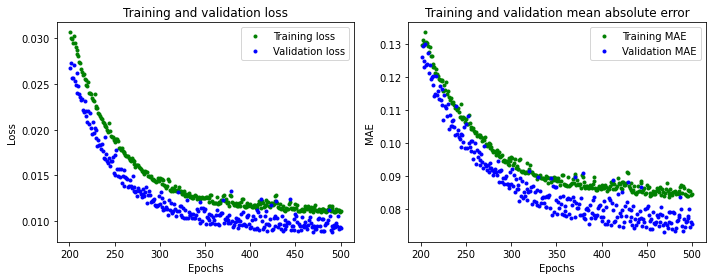

In [15]:
# Draw a graph of the loss, which is the distance between
# the predicted and actual values during training and validation.
train_loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(train_loss) + 1)

# Exclude the first few epochs so the graph is easier to read
SKIP = 200

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)

plt.plot(epochs[SKIP:], train_loss[SKIP:], 'g.', label='Training loss')
plt.plot(epochs[SKIP:], val_loss[SKIP:], 'b.', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)

# Draw a graph of mean absolute error, which is another way of
# measuring the amount of error in the prediction.
train_mae = history.history['mae']
val_mae = history.history['val_mae']

plt.plot(epochs[SKIP:], train_mae[SKIP:], 'g.', label='Training MAE')
plt.plot(epochs[SKIP:], val_mae[SKIP:], 'b.', label='Validation MAE')
plt.title('Training and validation mean absolute error')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()

plt.tight_layout()

Great results! From these graphs, we can see several exciting things:

*   The overall loss and MAE are much better than our previous network
*   Metrics are better for validation than training, which means the network is not overfitting

The reason the metrics for validation are better than those for training is that validation metrics are calculated at the end of each epoch, while training metrics are calculated throughout the epoch, so validation happens on a model that has been trained slightly longer.

This all means our network seems to be performing well! To confirm, let's check its predictions against the test dataset we set aside earlier:


7/7 [==============================] - 0s 972us/step - loss: 0.0112 - mae: 0.0830


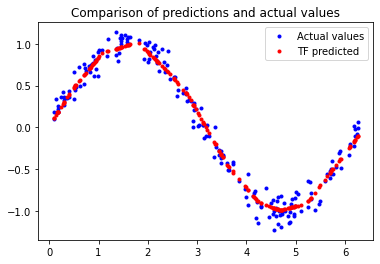

In [16]:
# Calculate and print the loss on our test dataset
test_loss, test_mae = model.evaluate(x_test, y_test)

# Make predictions based on our test dataset
y_test_pred = model.predict(x_test)

# Graph the predictions against the actual values
plt.clf()
plt.title('Comparison of predictions and actual values')
plt.plot(x_test, y_test, 'b.', label='Actual values')
plt.plot(x_test, y_test_pred, 'r.', label='TF predicted')
plt.legend()
plt.show()

Much better! The evaluation metrics we printed show that the model has a low loss and MAE on the test data, and the predictions line up visually with our data fairly well.

The model isn't perfect; its predictions don't form a smooth sine curve. For instance, the line is almost straight when `x` is between 1 and 2. If we wanted to go further, we could try further increasing the capacity of the model, perhaps using some techniques to defend from overfitting.

However, an important part of machine learning is *knowing when to stop*. This model is good enough for our use case - which is to make some LEDs blink in a pleasing pattern.



## Generate a TensorFlow Lite Model

### 1. Generate Models with and without Quantization
We now have an acceptably accurate model. We'll use the [TensorFlow Lite Converter](https://www.tensorflow.org/lite/convert) to convert the model into a special, space-efficient format for use on memory-constrained devices.

Since this model is going to be deployed on a microcontroller, we want it to be as tiny as possible! One technique for reducing the size of a model is called [quantization](https://www.tensorflow.org/lite/performance/post_training_quantization). It reduces the precision of the model's weights, and possibly the activations (output of each layer) as well, which saves memory, often without much impact on accuracy. Quantized models also run faster, since the calculations required are simpler.

In the following cell, we'll convert the model twice: once with quantization, once without.

In [17]:
# Convert the model to the TensorFlow Lite format without quantization
converter = tf.lite.TFLiteConverter.from_saved_model(MODEL_TF)
model_no_quant_tflite = converter.convert()

# Save the model to disk
open(MODEL_NO_QUANT_TFLITE, "wb").write(model_no_quant_tflite)

# Convert the model to the TensorFlow Lite format with quantization
def representative_dataset_generator():
  for value in x_train:
    yield [np.array(value, dtype=np.float32, ndmin=2)]

# Set the optimization flag - DEFAULT includes quantization.
converter.optimizations = [tf.lite.Optimize.DEFAULT]

# Enforce integer only quantization to reduce model size
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.int8
converter.inference_output_type = tf.int8

# Provide a representative dataset to ensure we quantize correctly.
converter.representative_dataset = representative_dataset_generator

model_tflite = converter.convert()

# Save the model to disk
open(MODEL_TFLITE, "wb").write(model_tflite)

2488

### 2. Compare Model Performance

To prove these models are accurate even after conversion and quantization, we'll compare their predictions and loss on our test dataset.

**Helper functions**

We define the `predict` (for predictions) and `evaluate` (for loss) functions for TFLite models. 

*Note: These are already included in a TF model, but not in  a TFLite model.*

In [18]:
def predict_tflite(tflite_model, x_test):
  # Prepare the test data
  x_test_ = x_test.copy()
  x_test_ = x_test_.reshape((x_test.size, 1))
  x_test_ = x_test_.astype(np.float32)

  # Initialize the TFLite interpreter
  interpreter = tf.lite.Interpreter(model_content=tflite_model)
  interpreter.allocate_tensors()

  input_details = interpreter.get_input_details()[0]
  output_details = interpreter.get_output_details()[0]

  # If required, quantize the input layer (from float to integer)
  input_scale, input_zero_point = input_details["quantization"]
  if (input_scale, input_zero_point) != (0.0, 0):
    x_test_ = x_test_ / input_scale + input_zero_point
    x_test_ = x_test_.astype(input_details["dtype"])
  
  # Invoke the interpreter
  y_pred = np.empty(x_test_.size, dtype=output_details["dtype"])
  for i in range(len(x_test_)):
    interpreter.set_tensor(input_details["index"], [x_test_[i]])
    interpreter.invoke()
    y_pred[i] = interpreter.get_tensor(output_details["index"])[0]
  
  # If required, dequantized the output layer (from integer to float)
  output_scale, output_zero_point = output_details["quantization"]
  if (output_scale, output_zero_point) != (0.0, 0):
    y_pred = y_pred.astype(np.float32)
    y_pred = (y_pred - output_zero_point) * output_scale

  return y_pred

def evaluate_tflite(tflite_model, x_test, y_true):
  global model
  y_pred = predict_tflite(tflite_model, x_test)
  loss_function = tf.keras.losses.get(model.loss)
  loss = loss_function(y_true, y_pred).numpy()
  return loss

**1. Predictions**

In [19]:
# Calculate predictions
y_test_pred_tf = model.predict(x_test)
y_test_pred_no_quant_tflite = predict_tflite(model_no_quant_tflite, x_test)
y_test_pred_tflite = predict_tflite(model_tflite, x_test)

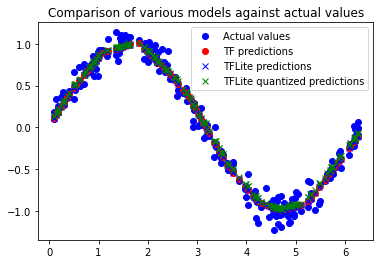

In [20]:
# Compare predictions
plt.clf()
plt.title('Comparison of various models against actual values')
plt.plot(x_test, y_test, 'bo', label='Actual values')
plt.plot(x_test, y_test_pred_tf, 'ro', label='TF predictions')
plt.plot(x_test, y_test_pred_no_quant_tflite, 'bx', label='TFLite predictions')
plt.plot(x_test, y_test_pred_tflite, 'gx', label='TFLite quantized predictions')
plt.legend()
plt.show()

**2. Loss (MSE/Mean Squared Error)**

In [21]:
# Calculate loss
loss_tf, _ = model.evaluate(x_test, y_test, verbose=0)
loss_no_quant_tflite = evaluate_tflite(model_no_quant_tflite, x_test, y_test)
loss_tflite = evaluate_tflite(model_tflite, x_test, y_test)

In [22]:
# Compare loss
df = pd.DataFrame.from_records(
    [["TensorFlow", loss_tf],
     ["TensorFlow Lite", loss_no_quant_tflite],
     ["TensorFlow Lite Quantized", loss_tflite]],
     columns = ["Model", "Loss/MSE"], index="Model").round(4)
df

,Loss/MSE
Model,
TensorFlow,0.0112
TensorFlow Lite,0.0112
TensorFlow Lite Quantized,0.0115


**3. Size**

In [23]:
# Calculate size
size_tf = os.path.getsize(MODEL_TF)
size_no_quant_tflite = os.path.getsize(MODEL_NO_QUANT_TFLITE)
size_tflite = os.path.getsize(MODEL_TFLITE)

In [24]:
# Compare size
pd.DataFrame.from_records(
    [["TensorFlow", f"{size_tf} bytes", ""],
     ["TensorFlow Lite", f"{size_no_quant_tflite} bytes ", f"(reduced by {size_tf - size_no_quant_tflite} bytes)"],
     ["TensorFlow Lite Quantized", f"{size_tflite} bytes", f"(reduced by {size_no_quant_tflite - size_tflite} bytes)"]],
     columns = ["Model", "Size", ""], index="Model")

,Size,
Model,,
TensorFlow,160 bytes,
TensorFlow Lite,2788 bytes,(reduced by -2628 bytes)
TensorFlow Lite Quantized,2488 bytes,(reduced by 300 bytes)


### **Summary**

We can see from the predictions (graph) and loss (table) that the original TF model, the TFLite model, and the quantized TFLite model are all close enough to be indistinguishable - even though they differ in size (table). This implies that the quantized (smallest) model is ready to use!

*Note: The quantized (integer) TFLite model is just a few hundred bytes smaller than the original (float) TFLite model - a tiny reduction in size! This is because the model is already so small that quantization has little effect. Complex models with more weights, can have upto a 4x reduction in size!*

## Generate a TensorFlow Lite for Microcontrollers Model
The final step is to convert the TensorFlow Lite quantized model into a C source file that can be loaded by TensorFlow Lite for Microcontrollers. Most microcontrollers don't have a filesystem so we need to provide the model as a C source file that can be loaded directly into memory. The model itself is defined as an array of bytes so we can use a Unix tool called xxd to convert a TFLite file into the required format.

In [25]:
# Install xxd if it is not available
!apt-get update && apt-get -qq install xxd
# Convert to a C source file, i.e, a TensorFlow Lite for Microcontrollers model
!xxd -i {MODEL_TFLITE} > {MODEL_TFLITE_MICRO}

zsh:1: command not found: apt-get


## Deploy to a Microcontroller

Follow the instructions in the [hello_CASA](https://github.com/djdunc/casa0018/tree/main/Week3/arduino) README.md to deploy this model on to an Arduino Nano BLE Sense.

To use the model generated in this notebook you can either download your model from the left hand folder navigation and edit it in your favourite code editor, or you can view the values displayed after running the following cell and copy paste those into your Arduino sketch.

In [26]:
# Print the C source file
!cat {MODEL_TFLITE_MICRO}

unsigned char models_model_tflite[] = {
  0x1c, 0x00, 0x00, 0x00, 0x54, 0x46, 0x4c, 0x33, 0x14, 0x00, 0x20, 0x00,
  0x1c, 0x00, 0x18, 0x00, 0x14, 0x00, 0x10, 0x00, 0x0c, 0x00, 0x00, 0x00,
  0x08, 0x00, 0x04, 0x00, 0x14, 0x00, 0x00, 0x00, 0x1c, 0x00, 0x00, 0x00,
  0x98, 0x00, 0x00, 0x00, 0xc8, 0x00, 0x00, 0x00, 0x1c, 0x03, 0x00, 0x00,
  0x2c, 0x03, 0x00, 0x00, 0x30, 0x09, 0x00, 0x00, 0x03, 0x00, 0x00, 0x00,
  0x01, 0x00, 0x00, 0x00, 0x04, 0x00, 0x00, 0x00, 0x60, 0xf7, 0xff, 0xff,
  0x10, 0x00, 0x00, 0x00, 0x18, 0x00, 0x00, 0x00, 0x28, 0x00, 0x00, 0x00,
  0x44, 0x00, 0x00, 0x00, 0x05, 0x00, 0x00, 0x00, 0x73, 0x65, 0x72, 0x76,
  0x65, 0x00, 0x00, 0x00, 0x0f, 0x00, 0x00, 0x00, 0x73, 0x65, 0x72, 0x76,
  0x69, 0x6e, 0x67, 0x5f, 0x64, 0x65, 0x66, 0x61, 0x75, 0x6c, 0x74, 0x00,
  0x01, 0x00, 0x00, 0x00, 0x04, 0x00, 0x00, 0x00, 0xbc, 0xff, 0xff, 0xff,
  0x09, 0x00, 0x00, 0x00, 0x04, 0x00, 0x00, 0x00, 0x07, 0x00, 0x00, 0x00,
  0x64, 0x65, 0x6e, 0x73, 0x65, 0x5f, 0x34, 0x00, 0x01, 0x00, 0x00, 0x00